# Life Cycle Assessement of passenger air transport

````{card}
Author
^^^
Félix POLLET <br>
[felix.pollet@isae-supaero.fr](felix.pollet@isae-supaero.fr)
````

The purpose of this notebook is to provide a first insight into the LCA methodology with a case study in aviation. No specific programming knowledge is required, as the aim is not to become an expert LCA developer, but rather to gain a basic understanding of how to analyse and interpret the results.

## 1. Goal and scope

The first phase of an LCA study is to define the objective and the scope. This is a crucial step because it determines your results and how you interpret and review them. Specifically, the following elements need to be defined:

* **Goal**: What is the purpose of the study? Do you want to know the environmental impacts of an existing product/system? To compare different products? Or to guide the design of a product under development? You can also define who the study is for (R&D engineers? Customers? Decision makers inside or outside your organisation?)

* **Product & Functional Unit**: What is the function of the product or system you are evaluating? For example, will you be evaluating an aircraft for fire fighting? Or for passenger transport (short/long haul)? This involves defining a functional unit, which is a quantification of the function and performance requirements. The functional unit must therefore reflect a quantity (e.g. move $x$ passengers over $y$ kilometres), a performance (e.g. for long distances) and a duration (e.g. for a period of 25 years).

* **Boundaries**: What is included in the study? What is outside the scope? In particular, it must be made clear if any phase of the life cycle is excluded. This will be very important when collecting data for the Life Cycle Inventory.
  
* **Methodological choices**: What LCIA methods will you use? Where will the supporting data come from (primary data from your company or an external database such as EcoInvent)? 


```{exercise} Goal & scope for passenger air transport LCA
:label: goal

Define the goal and scope for the current case study.
```


### Python setup
Now that the goal & scope are defined, let's start the LCA calculations! The following lines allow you to set up the project and import the necessary materials for the needs of the case study. Run them without any changes.

In [1]:
# Import libraries
import brightway2 as bw
import os 
import lca_algebraic as agb
from sympy import init_printing
import matplotlib.pyplot as plt
from supporting_data.helpers import *

# Pretty print for Sympy
init_printing()

# Set current project
bw.projects.set_current('LCA_course')
agb.resetParams()

# Import database for aircraft LCA model
agb.import_db("supporting_data/db_aircraft.bw2")
USER_DB = 'Foreground Aircraft'

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/22/2024 16:52:16
  Finished: 04/22/2024 16:52:16
  Total time elapsed: 00:00:00
  CPU %: 2.60
  Memory %: 1.22


## 2. Climate impact of aircraft production

As a preliminary exercise, we will narrow the scope to the climate impact of the aircraft production.

The representative aircraft for this LCA study has an operating empty weight (OEW) of 135 tons (similar to a Boeing B787-10). The mass breakdown and the energy consumption from the manufacturing facilities are provided in the following table.

:::{table} Table: Amounts of a material and energy required for the aircraft production
:widths: auto
:align: center

| Material, Energy, or Substance | Amount |
| --- | --- |
| Aluminium | 56.5% of OEW |
| Composite | 25% of OEW |
| Steel | 11.5% of OEW |
| Titanium | 4.5% of OEW |
| Nickel | 2.5% of OEW |
| Electricity (facilities and manufacturing processes) | 3 500 kWh |
:::

A detailed LCA study would require the collection of data on the production of each material/energy/substance. For example, the production of wrought aluminium requires some primary aluminium, electricity to produce heat and a mix of chemicals. The production of electricity requires a mix of power plants, and so on. In this course, to facilitate data collection, we use a database ([*EcoInvent*](https://ecoinvent.org/)) which provides data sets for a number of pre-defined *activities*.

````{prf:definition} Activity
:label: activity

**Activity**: making or doing something. Activities include human activities (production, consumption, and market activities, as well as accumulation of stocks) and environmental mechanisms.
````

The following lines enable you to select from the EcoInvent database the activities related to the production of aluminium, composite and steel, accounting for the transport of the components to the final assembly line:

In [2]:
# Selection of activities 
alu = agb.findTechAct("market for aluminium, wrought alloy")
composite = agb.findTechAct("market for carbon fibre reinforced plastic, injection moulded")
steel = agb.findTechAct("market for steel, chromium steel 18/8")

:::{hint} (Hint) Market activity
A *market activity* represents an average mix of production activities, and accounting for the transportation and potential losses of products from the production sites to the consumer's place.
:::

A quick documentation for each activity is available using the Python function `as_dict()`. Pay particular attention to the unit (e.g. kilogram of material produced) in which the activities are provided.

In [3]:
# Access to documentation of the activity
alu.as_dict()

{'comment': "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis is the market for  'aluminium, wrought alloy', in the Global geography.\nIn this market, expert judgement was used to develop product specific transport distance estimations.",
 'classifications': [('EcoSpold01Categories', 'metals/extraction'),
  ('ISIC rev.4 ecoinvent',
   '2420:Manufacture of basic precious and other non-ferrous metals'),
  ('CPC',
   '88602: Basic precious and other non-ferrous metal manufacturing services')],
 'activity type': 'market activity',
 'activity': 'b180f717-b151-51e6-b27d-958075016be3',
 'database': 'ecoinvent-3.10-cutoff',
 'filename'

:::{hint} (Hint) Geographic location
When available in the database, it is possible to define a geographic location to further refine the assessment. In EcoInvent the default location `GLO` refers to an average global value. `CN` refers to a production in China, `US` to the United States, etc. `RoW` corresponds to a global average but excluding the other regions that are included for that particular set of data (e.g., `GLO` minus `CN` and `US`).
:::

In [4]:
# Activities with geographic selection
elec = agb.findTechAct("market group for electricity, medium voltage", loc='GLO')  # global average mix
elec = agb.findTechAct("market group for electricity, medium voltage", loc='Europe without Switzerland')  # European mix
nickel = agb.findTechAct("market for nickel, class 1", loc='GLO')
titanium = agb.findTechAct("market for titanium", loc='GLO')

:::{hint} (Hint) Database exploration
If you want to further explore the EcoInvent database, you can make a search for a specific word as in the following cell of code.
:::


In [5]:
agb.findTechAct("nickel*", single=False)  # Find all activities in EcoInvent that contain the word 'nickel'

['nickel sulfate production' (kilogram, GLO, None),
 'nickel mine operation and benefication to nickel concentrate, 7% Ni' (kilogram, RoW, None),
 'nickel mine operation and benefication to nickel concentrate, 7% Ni' (kilogram, CN, None),
 'market for nickel sulfate' (kilogram, GLO, None),
 'market for nickel, class 1' (kilogram, GLO, None),
 'processing of nickel-rich materials' (kilogram, GLO, None),
 'electrolyte, nickel-rich to generic market for nickel-rich materials' (kilogram, GLO, None),
 'nickel concentrate, 16% Ni to generic market for nickel-rich materials' (kilogram, GLO, None),
 'nickel mine operation and benefication to nickel concentrate, 16% Ni' (kilogram, CA-QC, None),
 'smelting and refining of nickel concentrate, 7% Ni' (kilogram, CN, None),
 'market for electrolyte, nickel-rich' (cubic meter, GLO, None),
 'market for nickel smelter slag' (kilogram, CH, None),
 'market for nickel smelter slag' (kilogram, RoW, None),
 'smelting and refining of nickel concentrate, 16% 

The next step is to aggregate the individual activities to represent the parent activity, here the production of an aircraft.

```{exercise} Aircraft production activity
:label: goal

Complete the following lines of code to define the activity of aircraft production.
```

In [6]:
# Create an activity for aircraft production
aircraft_production = agb.newActivity(USER_DB,
    "aircraft production",  # declare the name of the new activity
    "unit",  # unit in which the activity is expressed. Here, the unit is 'one unit of aircraft'.
    {  # The following lines define the amount of each sub-activity that is required to achieve the parent activity
        alu: 0.6*135e3,  # [kg] amount of aluminium required for the production of one aircraft
        composite: 0.25*135e3,  # [kg] amount of composite required for the production of one aircraft
        #... TO COMPLETE
    }
)

The last step to obtain the LCA results is to select an LCIA method for calculating the impact on climate change. In this example, we use the *Environmental Footprint* (EF) method adopted by the European Commission as a standard to help companies to calculate their environmental performance.

In [7]:
# Select LCIA method for climate change
climate_change = agb.findMethods("climate change", mainCat="EF v3.1")[0]

# Hint: all available methods for calculation of climate change can be listed by uncommenting the following line
# agb.findMethods("climate change")

And voilà! Everything is now ready to calculate the impact on climate change related to the production of an aircraft.

In [8]:
agb.compute_impacts(
    
    # Activity to assess
    aircraft_production, 
    
    # list of impact(s) to consider
    [climate_change], 
)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,climate change - global warming potential (GWP100)[kg CO2-Eq]
aircraft production,3.96834e+06


That's a lot of CO2 (is it?). What if we express this impact per passenger-kilometre to make it easier to interpret?

In [9]:
agb.compute_impacts(
    
    # Activity/Process to assess
    aircraft_production, 
    
    # list of impacts to consider
    [climate_change], 
    
    # The impacts will be divided by the functional unit
    functional_unit=4.35e10  # estimated number of pax.km over the aircraft life cycle, to obtain a score per passenger.kilometer
)

,climate change - global warming potential (GWP100)[kg CO2-Eq]
aircraft production,9.12263e-05


```{exercise} Contribution of aircraft production to climate change
:label: aircraft_production

How much do you think aircraft production contributes to the overall impact of transporting a passenger?
```

In the next section, we will answer this question by evaluating the impact of transporting a passenger, taking into account the other phases of the lifecycle such as the combustion of kerosene during the flight.

## 3. Climate impact including the entire life cycle

A similar approach to aircraft production has been used to define the other activities that occur throughout the life cycle related to transporting a passenger, namely:

* The airport construction, maintenance and decommission
  
* The production and distribution of kerosene
  
* The combustion of kerosene during the flight

The decommission of the aircraft at the end of its life (e.g. recycling and disposal) is not taken into account here. All life cycle stages are then aggregated to the final activity, `passenger transport, aircraft`, which is retrieved in the following cell.

In [10]:
# Activity representing the entire lifecycle related to the transportation of a passenger
passenger_transport = agb.findActivity(
    name="passenger transport, aircraft",
    db_name=USER_DB
)

In [11]:
# Check the unit of the activity
passenger_transport['unit']

'one passenger kilometer'

```{exercise} Contribution of aircraft production to climate change
:label: air_transport_climate

Run the next cells to evaluate the climate impact for the transportation of one passenger over one kilometer. 

* Compare the impacts of aircraft production to those obtained in the previous section. Are they similar? If not, what could explain the difference?

* What are the main contributors to climate change?
```


In [13]:
results_climate = agb.compute_impacts(
    
    # Activity to assess
    passenger_transport, 
    
    # list of impacts to consider
    [climate_change], 

    # Split impacts to get contributions from each phase of the lifecycle
    axis="phase",
)
results_climate

,climate change - global warming potential (GWP100)[kg CO2-Eq]
phase,
_other_,0
aircraft_production,0.000184857
airport,0.00161083
combustion,0.0832676
kerosene_production,0.0223387
*sum*,0.107402


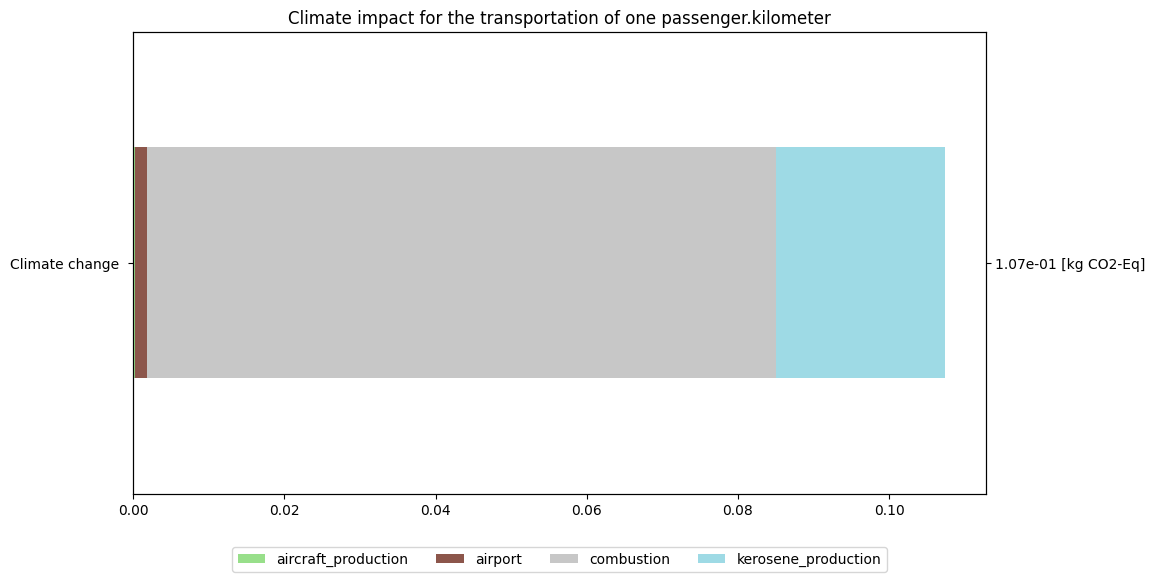

In [14]:
# Plot the results
ax = plot_lca(results_climate)
ax.set_title('Climate impact for the transportation of one passenger.kilometer');

## 4. Extension to other impact categories

This section extends the LCA study to assess the impacts of air transport on other environmental categories. The list of LCIA methods is provided below.

In [15]:
# List of impact methods to consider
impact_methods = agb.findMethods("", mainCat="EF v3.1")
impact_methods = [impact_methods[i] for i in [0, 1, 5, 8, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 23, 24]]  # 16 different impact categories

# Display the selected methods
df = pd.DataFrame(impact_methods, columns=['Methods package', 'Impact category', 'Indicator (unit of measure)'])
with pd.option_context('display.max_colwidth', None):
  display(df)

,Methods package,Impact category,Indicator (unit of measure)
0,EF v3.1,acidification,accumulated exceedance (AE)
1,EF v3.1,climate change,global warming potential (GWP100)
2,EF v3.1,ecotoxicity: freshwater,comparative toxic unit for ecosystems (CTUe)
3,EF v3.1,energy resources: non-renewable,abiotic depletion potential (ADP): fossil fuels
4,EF v3.1,eutrophication: freshwater,fraction of nutrients reaching freshwater end compartment (P)
5,EF v3.1,eutrophication: marine,fraction of nutrients reaching marine end compartment (N)
6,EF v3.1,eutrophication: terrestrial,accumulated exceedance (AE)
7,EF v3.1,human toxicity: carcinogenic,comparative toxic unit for human (CTUh)
8,EF v3.1,human toxicity: non-carcinogenic,comparative toxic unit for human (CTUh)
9,EF v3.1,ionising radiation: human health,human exposure efficiency relative to u235


:::{hint} (Hint) Description of impact categories
A description of each impact category covered by Environmental Footprint (EF) can be found on page 18 of [this document](https://op.europa.eu/en/publication-detail/-/publication/c43b9684-4521-11ed-92ed-01aa75ed71a1/language-en).
:::

In [16]:
# Compute impacts
results_lca = agb.compute_impacts(
    
    # Activity/Process to assess
    passenger_transport, 
    
    # list of impacts to consider
    impact_methods, 

    # Get contributions by lifecycle phase
    axis="phase",
)
results_lca

,acidification - accumulated exceedance (AE)[mol H+-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq],human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq],particulate matter formation - impact on human health[disease incidence],photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]
phase,,,,,,,,,,,,,,,,
_other_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aircraft_production,1.10345e-06,0.000184857,0.000644861,0.00607986,3.86691e-08,1.57706e-07,1.63597e-06,5.62315e-13,1.25609e-12,7.17363e-06,0.000618457,5.82394e-10,6.43213e-12,1.1438e-11,1.10463e-06,3.31613e-05
airport,7.74418e-06,0.00161083,0.00962458,0.0219254,6.00014e-07,1.52828e-06,1.59305e-05,3.22049e-12,1.63766e-11,0.000185135,0.0185883,1.15795e-08,2.21238e-11,6.94769e-11,7.24577e-06,0.000399533
combustion,0.000351456,0.0832676,0.000293218,0,0,0.000169297,0.001854,2.74177e-12,9.63791e-10,0,0,0,0,9.24347e-11,0.000442096,8.77986e-06
kerosene_production,0.000102308,0.0223387,0.0905821,1.39698,1.21915e-06,1.56525e-05,0.000166463,9.43184e-11,1.16501e-10,0.000292062,0.0868826,1.78936e-08,1.41395e-09,8.99489e-10,0.000192961,0.00170777
*sum*,0.000462612,0.107402,0.101145,1.42499,1.85783e-06,0.000186636,0.00203803,1.00843e-10,1.09792e-09,0.000484371,0.106089,3.00555e-08,1.44251e-09,1.07284e-09,0.000643407,0.00214925


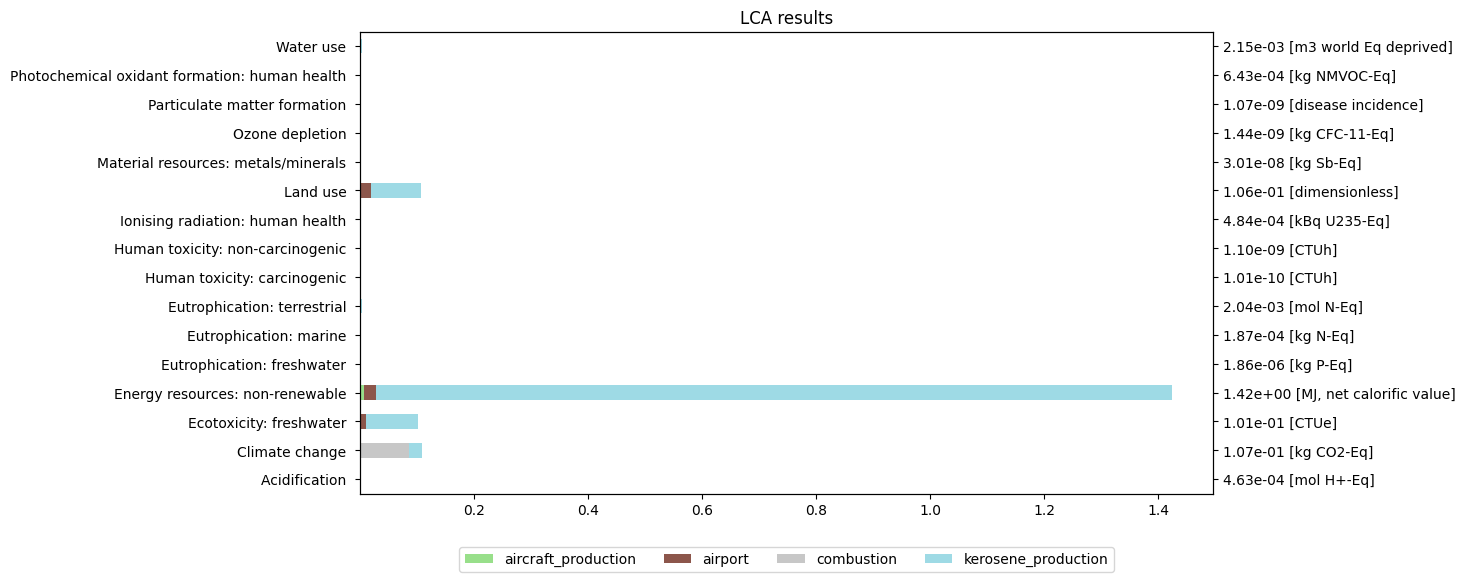

In [17]:
# Display impacts
ax = plot_lca(results_lca)
ax.set_title('LCA results');

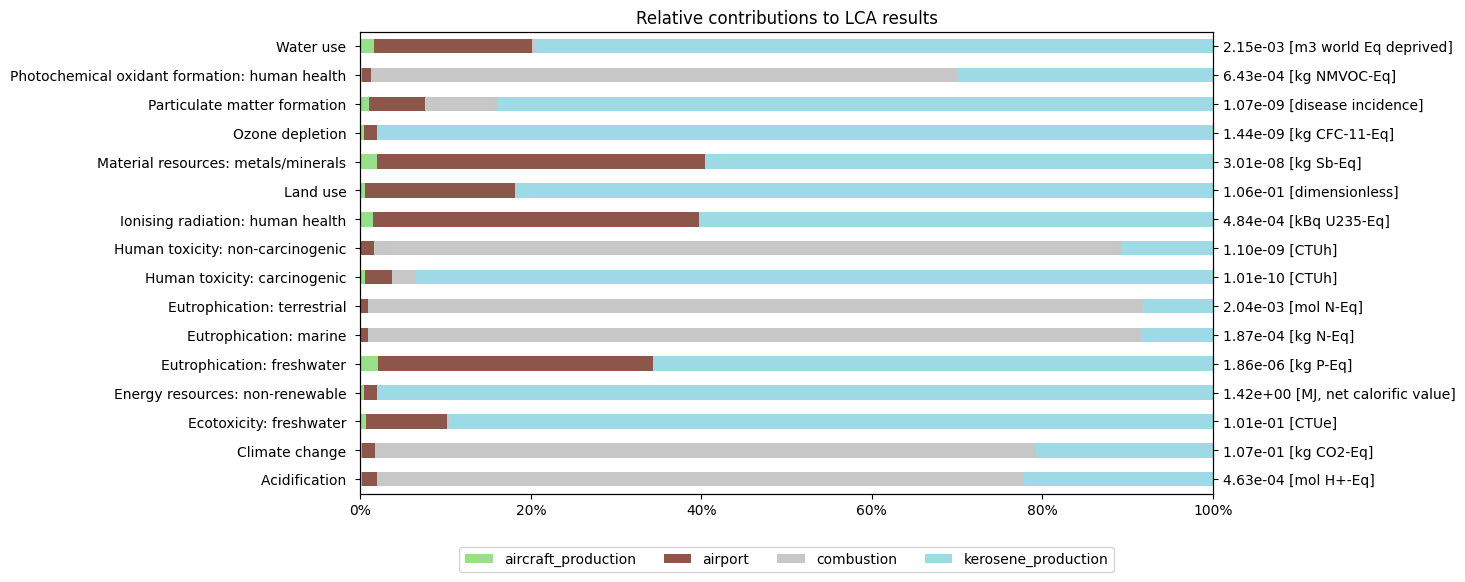

In [18]:
# Relative contributions for each impact category
ax = plot_lca(results_lca, relative=True)
ax.set_title('Relative contributions to LCA results');

```{exercise} Main contributors
:label: interpretation_1

What are the main contributors to each impact categories?

```

```{solution} interpretation_1
:class: dropdown
For most of the impact categories, most of the casualties are caused by producing fuel and burning it in flight.

```

```{exercise} Critical impact categories
:label: interpretation_2

What are the critical impact categories?

```

```{solution} interpretation_2
:class: dropdown

The key point here is what we define as a critical impact category. Critical in relation to what? With respect to the total contribution of human activities? Or relative to other impact categories? If so, how can we define the relative importance of the categories, given that they are expressed with inhomogenous indicators? This is what makes the first graph difficult to read, as we are trying to display multiple impacts measured in different units...

One answer to these questions lies in the so-called normalisation and weighting steps, which are carried out in the next section.

```

## 5. Facilitate interpretation and decision-making: normalisation and weighting

Although normalisation and weighting are **not** required by the ISO standards on LCA, they are frequently applied in practice for different reasons, such as identifying important impact categories, understanding the meaning of results by comparing with more familiar references or solving tradeoffs between results. 

### 5.a) Normalisation

```{admonition} Definition
According to the ISO 14044 standard on LCA, normalisation is defined as *"calculating the magnitude of category indicator results relative to reference information"*. The reference information can be a product (e.g. another mode of transport), a system representing a country or the
(e.g. the impact of human activities on a global scale in a given year), or even derived from the planetary boundaries.

The purpose of the normalisation step is threefold. It enables

1. To compare the results in order to check plausibility (order of magnitude),
   
2. To compare the results with a reference situation that is external to or independent from the case studies, which may facilitate the interpretation and communication of the impact results,

3. To be free of unit constraints as a preparation to the weighting step, with the impacts expressed on a common scale.
```


:::{caution}
The main criticism regarding normalisation is the bias due to the choice of normalisation references, which may change the conclusions of the study. Therefore, the normalisation reference should be clearly stated when communicating the results.
:::

In this study, the [normalisation factors from the Environmental Footprint method](https://publications.jrc.ec.europa.eu/repository/handle/JRC130796) are used for the normalisation step. The value of these normalisation factors represent the average impacts of a human in the year 2010, such that the normalised LCA results are expressed in "person equivalent".

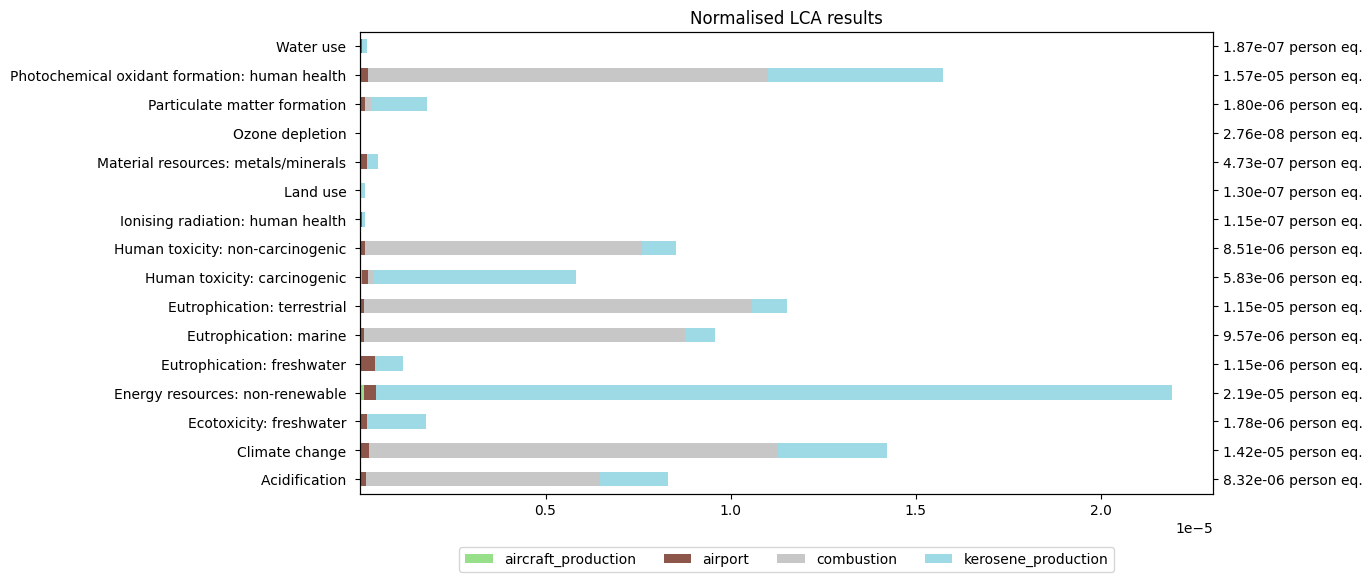

In [23]:
# Normalised results
results_norm = results_lca.copy()
results_norm["acidification - accumulated exceedance (AE)[mol H+-Eq]"] /= 5.56e01
results_norm["climate change - global warming potential (GWP100)[kg CO2-Eq]"] /= 7.55e03
results_norm["ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]"] /= 5.67e04
results_norm["energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]"] /= 6.50e04
results_norm["eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq]"] /= 1.61
results_norm["eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq]"] /= 1.95e01
results_norm["eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq]"] /= 1.77e02
results_norm["human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh]"] /= 1.73e-05
results_norm["human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh]"] /= 1.29e-04
results_norm["ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq]"] /= 4.22e03
results_norm["land use - soil quality index[dimensionless]"] /= 8.19e05
results_norm["material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq]"] /= 6.36e-02
results_norm["ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq]"] /= 5.23e-02
results_norm["particulate matter formation - impact on human health[disease incidence]"] /= 5.95e-04
results_norm["photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq]"] /= 4.09e01
results_norm["water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]"] /= 1.15e04

# Display normalised impacts
ax = plot_lca(results_norm, custom_units='person eq.')
ax.set_title('Normalised LCA results');

### 5.b) Weighting 

```{admonition} Definition
According to the ISO 14044 standard on LCA, weighting is defined as *"converting and possibly aggregating indicator results across impact categories using numerical factors based on value-choices"*. The weights applied to the normalised results are intended to reflect the relative importance of impacts according to specific value choices. Examples of weighting approaches include the representation of regulatory targets (e.g. CO2 reduction target), preferences of people, experts or organisations, geography (local versus global) or economic considerations.

In particular, weighting can facilitate decision making in situations where tradeoffs between impact category results do not allow choosing one preferable solution among the alternatives or one improvement among possible ones.
```

:::{caution}
Because it is based on value judgement, ISO standards exclude the use of weighting to support comparative assertions intended to be disclosed to the public. However, both normalisation and weighting are mandatory steps in *Environmental Footprint* (EF). In any case, weighted results should not be communicated alone, i.e. they should be accompanied by the characterised and normalised results to ensure transparency.
:::

In this study, the results are weighted according to EF methods. The list of weighting factors, obtained from a panel of both expert and non-expert individuals, is available [here](https://eplca.jrc.ec.europa.eu/permalink/EF3_1/Normalisation_Weighting_Factors_EF_3.1.xlsx).

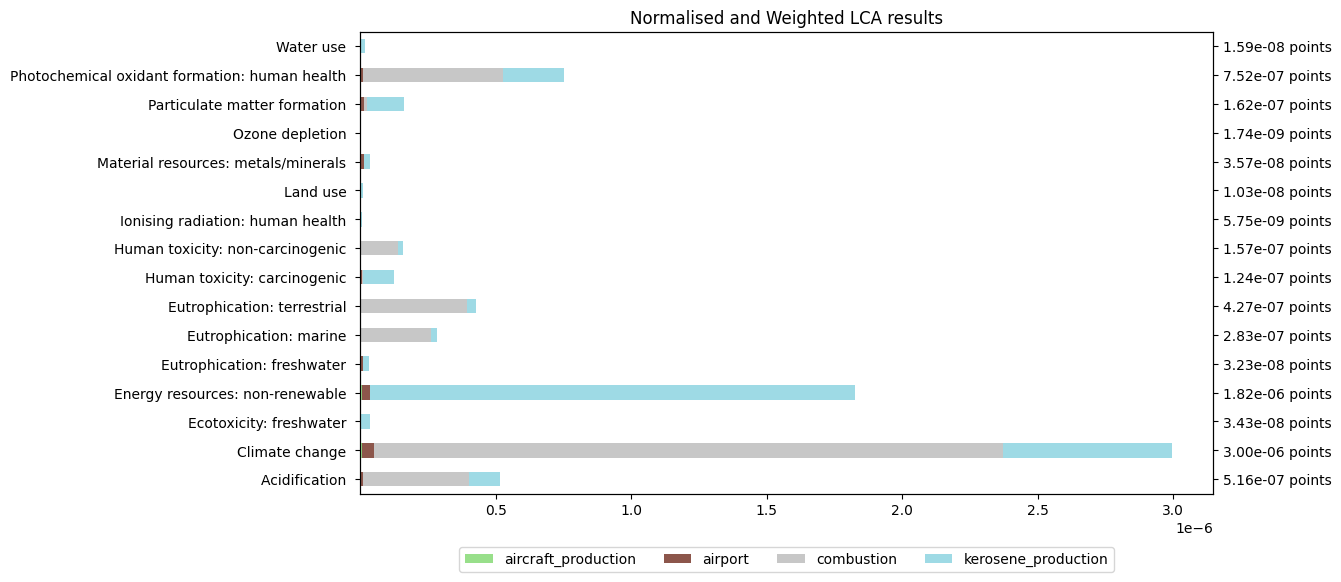

In [24]:
# Weighted results
results_weighted = results_norm.copy()
results_weighted["acidification - accumulated exceedance (AE)[mol H+-Eq]"] *= 0.0620
results_weighted["climate change - global warming potential (GWP100)[kg CO2-Eq]"] *= 0.2106
results_weighted["ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]"] *= 0.0192
results_weighted["energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]"] *= 0.0832
results_weighted["eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq]"] *= 0.0280
results_weighted["eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq]"] *= 0.0296
results_weighted["eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq]"] *= 0.0371
results_weighted["human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh]"] *= 0.0213
results_weighted["human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh]"] *= 0.0184
results_weighted["ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq]"] *= 0.0501
results_weighted["land use - soil quality index[dimensionless]"] *= 0.0794
results_weighted["material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq]"] *= 0.0755
results_weighted["ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq]"] *= 0.0631
results_weighted["particulate matter formation - impact on human health[disease incidence]"] *= 0.0896
results_weighted["photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq]"] *= 0.0478
results_weighted["water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]"] *= 0.0851

# Display weighted results
ax = plot_lca(results_weighted, custom_units='points')
ax.set_title('Normalised and Weighted LCA results');

```{exercise} Conclusion
:label: conclusion

Draw conclusions about the environmental impacts of passenger air transport. Provide some perspectives on how to mitigate these impacts and what methodological steps could be taken to consolidate the LCA study.

```

## Optional exercise: robustness to LCIA methods

In the interpretation phase of the LCA, it is important to assess the robustness of the results to some methodological choices. Apart from the definition of the scope of the LCA, robustness to the LCIA methods used in the calculations is important. 

```{exercise} Comparison of LCIA methods
:label: lciamethods

In the following cells, different LCIA methods are used to calculate the impact on climate change. Compare the results and explain why they differ. 

You can also try with other impact categories to investigate which ones are most influenced by the method selection.

```


In [25]:
# Select different LCIA methods for the climate change category
impact_methods = [agb.findMethods("climate change", mainCat=cat)[0] for cat in ["EF v3.0",
                                                                                "EF v3.1", 
                                                                                "ReCiPe 2016 v1.03, midpoint (H)", 
                                                                                "CML v4.8 2016",
                                                                                "IPCC 2021",
                                                                                "TRACI v2.1"
                                                                               ]]

In [26]:
# Show results obtained with different LCIA methods
results_climate_comparison = agb.compute_impacts(
    
    # Activity/Process to assess
    passenger_transport, 
    
    # list of impacts to consider
    impact_methods, 
)
results_climate_comparison

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],climate change - global temperature change potential (GTP100)[kg CO2-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq]
"passenger transport, aircraft",0.109578,0.107402,0.109243,0.106866,0.100809,0.105995
